In [12]:
# Install all required Python packages.
# - pandas/numpy: data handling
# - scipy: the optimizer we'll use (L-BFGS-B)
# - requests: download data from the web/API
# - tqdm: nice progress bars (optional)

!pip install -q pandas numpy scipy requests tqdm

In [23]:
# =========================
# Imports (libraries we use)
# =========================
import io, math, sys
from dataclasses import dataclass
from typing import Dict, Tuple, List, Optional

import numpy as np               # numerical arrays
import pandas as pd              # tables/dataframes
import requests                  # HTTP calls to API
from scipy.optimize import minimize  # optimizer for MLE

# ================================================
# 1) Configuration and name normalization helpers
# ================================================

# We train on the last 3 EPL seasons from football-data.co.uk (E0 = Premier League)
SEASON_CODES = ["2223", "2324", "2425"]  # 22/23, 23/24, 24/25
FBD_URL = "https://www.football-data.co.uk/mmz4281/{season}/E0.csv"

# We fetch the 2025/26 Premier League fixtures (with dates) from football-data.org
FDORG_FIXTURES_URL = "https://api.football-data.org/v4/competitions/PL/matches?season=2025"

# Team name mapping so different sources “agree” (e.g., "Tottenham Hotspur FC" -> "Tottenham")
NAME_MAP = {
    "Manchester United": "Man United",
    "Manchester City": "Man City",
    "Tottenham Hotspur": "Tottenham",
    "Tottenham Hotspur FC": "Tottenham",
    "Brighton & Hove Albion": "Brighton",
    "Brighton & Hove Albion FC": "Brighton",
    "Brighton and Hove Albion": "Brighton",
    "Wolverhampton Wanderers": "Wolves",
    "Wolverhampton Wanderers FC": "Wolves",
    "Newcastle United": "Newcastle",
    "Newcastle United FC": "Newcastle",
    "West Ham United": "West Ham",
    "West Ham United FC": "West Ham",
    "Nottingham Forest": "Nott'm Forest",
    "Nottingham Forest FC": "Nott'm Forest",
    "AFC Bournemouth": "Bournemouth",
    "AFC Bournemouth FC": "Bournemouth",
    "Sheffield United": "Sheffield United",
    "Leeds United": "Leeds",
    "Leicester City": "Leicester",
}

# =========================================================
# 2) Data download utilities (results + fixtures with dates)
# =========================================================

def _download_csv(url: str) -> pd.DataFrame:
    """Download a CSV from the web and parse into a DataFrame."""
    r = requests.get(url, timeout=30, headers={"User-Agent": "Mozilla/5.0"})
    r.raise_for_status()                          # fail fast if 404/500
    return pd.read_csv(io.StringIO(r.text))       # parse CSV text into DataFrame

def load_last_3_seasons() -> pd.DataFrame:
    """Fetch and combine the last three EPL seasons for model training."""
    frames: List[pd.DataFrame] = []
    for code in SEASON_CODES:
        url = FBD_URL.format(season=code)         # build season URL
        print(f"Downloading {code} → {url}")
        df = _download_csv(url)                   # grab the CSV

        # keep only columns we need
        keep = [c for c in ["Date", "HomeTeam", "AwayTeam", "FTHG", "FTAG"] if c in df.columns]
        df = df[keep].copy()

        # parse dates (football-data uses day-first)
        if "Date" in df.columns:
            df["Date"] = pd.to_datetime(df["Date"], dayfirst=True, errors="coerce")

        # drop rows missing essentials
        df = df.dropna(subset=["HomeTeam", "AwayTeam", "FTHG", "FTAG"])

        # ensure goals are ints
        df["FTHG"] = df["FTHG"].astype(int)
        df["FTAG"] = df["FTAG"].astype(int)

        frames.append(df)

    return pd.concat(frames, ignore_index=True)   # combine seasons vertically

def get_fdorg_fixtures(api_key: str) -> pd.DataFrame:
    """Fetch official 2025/26 fixtures with dates from football-data.org using your API key."""
    if not api_key.strip():
        raise RuntimeError("API key missing. Set API_KEY in the previous cell.")
    # Call API with X-Auth-Token header (as per the email instructions)
    r = requests.get(
        FDORG_FIXTURES_URL,
        headers={"X-Auth-Token": api_key, "User-Agent": "Mozilla/5.0"},
        timeout=30
    )
    # Helpful messages on common issues
    if r.status_code == 401:
        raise RuntimeError("Unauthorized (401). Check your football-data.org API key.")
    if r.status_code != 200:
        raise RuntimeError(f"API error {r.status_code}: {r.text[:200]}")
    data = r.json()

    # Build a clean fixtures table: Date, HomeTeam, AwayTeam
    rows = []
    for m in data.get("matches", []):
        home = m.get("homeTeam", {}).get("name", "")
        away = m.get("awayTeam", {}).get("name", "")
        date = m.get("utcDate", None)
        if home and away:
            rows.append({"Date": date, "HomeTeam": home, "AwayTeam": away})

    df = pd.DataFrame(rows)
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")   # to pandas datetime
    df = df.dropna(subset=["HomeTeam", "AwayTeam"]).reset_index(drop=True)
    return df

# ==================================
# 3) Name harmonization (very common)
# ==================================

def harmonize_names(df: pd.DataFrame, cols=("HomeTeam", "AwayTeam")) -> pd.DataFrame:
    """Map provider-specific names to unified naming (football-data.co.uk style)."""
    def map_name(x: str) -> str:
        if pd.isna(x):
            return x
        x = str(x).strip()
        return NAME_MAP.get(x, x)

    out = df.copy()
    for c in cols:
        out[c] = out[c].map(map_name)
    return out

def fuzzy_map_to_seen(target: List[str], known: List[str]) -> Dict[str, str]:
    """If a team name isn't an exact match, map to the closest known team using fuzzy match."""
    from difflib import get_close_matches
    mapping: Dict[str, str] = {}
    for t in target:
        if t in known:
            mapping[t] = t
        else:
            cand = get_close_matches(t, known, n=1, cutoff=0.6)
            mapping[t] = cand[0] if cand else t
    return mapping

# ===========================================
# 4) Dixon–Coles model (Poisson goals + tweaks)
# ===========================================

@dataclass
class DCParams:
    """Container for model parameters."""
    attack: Dict[str, float]   # team attacking strengths
    defense: Dict[str, float]  # team defensive strengths
    home_adv: float            # league-wide home advantage
    rho: float                 # low-score dependency (Dixon–Coles correction)

def poisson_prob(lmbda: float, k: int) -> float:
    """Poisson probability mass function P(X=k)."""
    return math.exp(-lmbda) * (lmbda ** k) / math.factorial(k)

def tau_dc(x: int, y: int, lam_h: float, lam_a: float, rho: float) -> float:
    """Dixon–Coles low-score dependence adjustment factor."""
    if x == 0 and y == 0: return 1 - lam_h * lam_a * rho
    if x == 0 and y == 1: return 1 + lam_h * rho
    if x == 1 and y == 0: return 1 + lam_a * rho
    if x == 1 and y == 1: return 1 - rho
    return 1.0

def decay_weight(days_diff: float, xi: float = 0.0065) -> float:
    """Exponential time decay so recent matches matter more."""
    return math.exp(-xi * days_diff)

class DixonColesModel:
    """Fits attack/defense strengths + home advantage + rho via MLE with time decay."""
    def __init__(self, xi: float = 0.0065, max_goals: int = 6):
        self.xi = xi
        self.max_goals = max_goals
        self.params_: Optional[DCParams] = None
        self.teams_: List[str] = []

    def _pack(self, P: DCParams) -> np.ndarray:
        """Flatten parameters into a vector for the optimizer."""
        return np.array(
            [P.attack[t] for t in self.teams_] +
            [P.defense[t] for t in self.teams_] +
            [P.home_adv, P.rho],
            dtype=float
        )

    def _unpack(self, vec: np.ndarray) -> DCParams:
        """Rebuild structured params from the optimizer vector."""
        T = len(self.teams_)
        atk = dict(zip(self.teams_, vec[:T]))
        dfn = dict(zip(self.teams_, vec[T:2*T]))
        home_adv = float(vec[-2]); rho = float(vec[-1])

        # Center around zero for identifiability
        atk_mu = float(np.mean(list(atk.values())))
        dfn_mu = float(np.mean(list(dfn.values())))
        atk = {k: v - atk_mu for k, v in atk.items()}
        dfn = {k: v - dfn_mu for k, v in dfn.items()}
        return DCParams(atk, dfn, home_adv, rho)

    def _nll(self, vec: np.ndarray, df: pd.DataFrame) -> float:
        """Negative log-likelihood over all historical matches."""
        P = self._unpack(vec)
        ll = 0.0
        for _, row in df.iterrows():
            h, a = row["HomeTeam"], row["AwayTeam"]
            gh, ga = int(row["FTHG"]), int(row["FTAG"])
            days = float(row.get("_days", 0.0))
            w = decay_weight(days, self.xi)

            # Expected goals from team strengths
            lam_h = math.exp(P.home_adv + P.attack[h] - P.defense[a])
            lam_a = math.exp(P.attack[a] - P.defense[h])

            # Independent Poisson × DC adjustment (low-score correlation)
            base = poisson_prob(lam_h, gh) * poisson_prob(lam_a, ga)
            p = max(base * tau_dc(gh, ga, lam_h, lam_a, P.rho), 1e-12)

            ll += w * math.log(p)
        return -ll

    def fit(self, results: pd.DataFrame) -> "DixonColesModel":
        """Fit parameters by maximizing the time-decayed likelihood."""
        df = results.copy()
        self.teams_ = sorted(set(df["HomeTeam"]).union(set(df["AwayTeam"])))

        # Compute days-since for time decay
        if "Date" in df.columns and df["Date"].notna().any():
            max_date = df["Date"].max()
            df["_days"] = (max_date - df["Date"]).dt.days.astype(float)
        else:
            df["_days"] = 0.0

        # Reasonable starting guess
        init = DCParams(
            attack={t: 0.0 for t in self.teams_},
            defense={t: 0.0 for t in self.teams_},
            home_adv=0.2,
            rho=0.0,
        )
        x0 = self._pack(init)

        # Optimize with L-BFGS-B
        res = minimize(self._nll, x0, args=(df,), method="L-BFGS-B", options={"maxiter": 400})
        if not res.success:
            raise RuntimeError(f"Optimization failed: {res.message}")

        self.params_ = self._unpack(res.x)
        return self

    def team_rates(self, home: str, away: str) -> Tuple[float, float]:
        """Return expected goals (λ_home, λ_away) for a given pairing."""
        assert self.params_ is not None, "Model not fitted."
        P = self.params_
        lam_h = math.exp(P.home_adv + P.attack[home] - P.defense[away])
        lam_a = math.exp(P.attack[away] - P.defense[home])
        return lam_h, lam_a

    def score_matrix(self, home: str, away: str) -> np.ndarray:
        """Full matrix of scoreline probabilities up to max_goals (0..6 by default)."""
        lam_h, lam_a = self.team_rates(home, away)
        pmf_h = np.array([poisson_prob(lam_h, k) for k in range(self.max_goals + 1)])
        pmf_a = np.array([poisson_prob(lam_a, k) for k in range(self.max_goals + 1)])
        M = np.outer(pmf_h, pmf_a)

        # Apply low-score adjustments for (0,0), (0,1), (1,0), (1,1)
        for x in (0, 1):
            for y in (0, 1):
                M[x, y] *= tau_dc(x, y, lam_h, lam_a, self.params_.rho)  # type: ignore

        # Normalize (numerical safety)
        M = M / M.sum()
        return M

    def probs_hda(self, home: str, away: str) -> Tuple[float, float, float, Tuple[int, int]]:
        """Return P(Home), P(Draw), P(Away) and the most-likely scoreline."""
        M = self.score_matrix(home, away)
        p_home = float(np.sum([M[i, j] for i in range(M.shape[0]) for j in range(M.shape[1]) if i > j]))
        p_draw = float(np.sum([M[i, i] for i in range(M.shape[0])]))
        p_away = float(1.0 - p_home - p_draw)
        ix = np.unravel_index(np.argmax(M), M.shape)
        return p_home, p_draw, p_away, (int(ix[0]), int(ix[1]))

# ====================================================
# 5) Prediction helpers (map names, handle new teams)
# ====================================================

def league_avgs(P: DCParams) -> Tuple[float, float]:
    """Compute league-average attack/defense to use for unseen (promoted) teams."""
    return float(np.mean(list(P.attack.values()))), float(np.mean(list(P.defense.values())))

def predict_all(model: DixonColesModel, fixtures: pd.DataFrame) -> pd.DataFrame:
    """Predict probabilities and tips for every fixture row."""
    fx = harmonize_names(fixtures, cols=("HomeTeam", "AwayTeam"))  # unify names
    seen = set(model.teams_)                                      # teams seen in training
    P = model.params_; assert P is not None

    # fuzzy map to closest known names (handles small naming differences)
    mapping = fuzzy_map_to_seen(sorted(set(fx["HomeTeam"]) | set(fx["AwayTeam"])), list(seen))

    # add any unseen teams as league-average, so we still produce predictions
    atk_avg, def_avg = league_avgs(P)
    for t in set(fx["HomeTeam"]).union(set(fx["AwayTeam"])):
        mapped = mapping.get(t, t)
        if mapped not in seen:
            P.attack[mapped] = atk_avg
            P.defense[mapped] = def_avg
            model.teams_.append(mapped)
            seen.add(mapped)

    # compute probabilities for each fixture
    rows = []
    for _, r in fx.iterrows():
        h = mapping.get(r["HomeTeam"], r["HomeTeam"])
        a = mapping.get(r["AwayTeam"], r["AwayTeam"])
        p_h, p_d, p_a, (sh, sa) = model.probs_hda(h, a)
        tip = "H" if p_h >= max(p_d, p_a) else ("D" if p_d >= max(p_h, p_a) else "A")
        rows.append({
            "Date": r.get("Date", pd.NaT),
            "HomeTeam": h,
            "AwayTeam": a,
            "P(Home)": round(p_h, 4),
            "P(Draw)": round(p_d, 4),
            "P(Away)": round(p_a, 4),
            "MostLikelyScore": f"{sh}-{sa}",
            "Tip": tip
        })
    return pd.DataFrame(rows).sort_values(["Date", "HomeTeam", "AwayTeam"]).reset_index(drop=True)

# ===========================================
# 6) Full pipeline: train → fetch fixtures → predict
# ===========================================

def run_pipeline_direct(api_key: str) -> pd.DataFrame:
    """Train on last 3 seasons, fetch 2025/26 fixtures with dates, and predict all matches."""
    print("Step 1/3: Download last 3 seasons (football-data.co.uk)")
    results = load_last_3_seasons()

    print("Step 2/3: Fit Dixon–Coles model (this can take ~10–30s)")
    model = DixonColesModel(xi=0.0065, max_goals=6).fit(results)

    print("Step 3/3: Fetch official 2025/26 fixtures (football-data.org) and predict")
    fixtures = get_fdorg_fixtures(api_key)

    preds = predict_all(model, fixtures)
    return preds

In [24]:
# This runs the end-to-end pipeline using the API_KEY from Step 2.
preds = run_pipeline_direct(API_KEY)

# Peek at the first few rows to confirm the format:
preds.head(10)

Step 1/3: Download last 3 seasons (football-data.co.uk)
Step 2/3: Fit Dixon–Coles model (this can take ~10–30s)
Step 3/3: Fetch official 2025/26 fixtures (football-data.org) and predict


,Date,HomeTeam,AwayTeam,P(Home),P(Draw),P(Away),MostLikelyScore,Tip
0,2025-08-15 19:00:00+00:00,Liverpool,Bournemouth,0.5589,0.2160,0.2251,1-1,H
1,2025-08-16 11:30:00+00:00,Aston Villa,Newcastle,0.3573,0.2442,0.3985,1-1,A
2,2025-08-16 14:00:00+00:00,Brighton,Fulham,0.4822,0.2194,0.2984,1-1,H
3,2025-08-16 14:00:00+00:00,Sunderland AFC,West Ham,0.3559,0.2751,0.3691,1-1,A
4,2025-08-16 14:00:00+00:00,Tottenham,Burnley,0.5230,0.2193,0.2577,1-1,H
5,2025-08-16 16:30:00+00:00,Wolves,Man City,0.1811,0.2099,0.6089,0-1,A
6,2025-08-17 13:00:00+00:00,Chelsea,Crystal Palace,0.4702,0.2571,0.2727,1-1,H
7,2025-08-17 13:00:00+00:00,Nott'm Forest,Brentford,0.3864,0.2416,0.3720,1-1,H
8,2025-08-17 15:30:00+00:00,Man United,Arsenal,0.1757,0.2380,0.5863,0-1,A
9,2025-08-18 19:00:00+00:00,Sheffield United,Everton,0.1138,0.1971,0.6890,0-1,A


In [25]:
# Save the predictions to a CSV file.
preds.to_csv("predictions_epl_2025_26.csv", index=False)
"Saved to predictions_epl_2025_26.csv"

'Saved to predictions_epl_2025_26.csv'

In [27]:
import pandas as pd
df = pd.read_csv("predictions_epl_2025_26.csv")
len(df), df["HomeTeam"].nunique(), df["AwayTeam"].nunique()

(380, 20, 20)

Loading training seasons: ['2223', '2324']
Fitting Dixon–Coles on train...
Loading test season: 2425
Predicting test season with the trained model...

=== Backtest on 2024/25 (trained on 22/23 + 23/24) ===
Log Loss: 1.0157   (↓ better)
Brier   : 0.6092   (↓ better)
RPS     : 0.2106   (↓ better)
Accuracy: 0.484   (↑ better)

Calibration (Home win) by probability bins:


,bin_mid,empirical_home_win,count
0,0.05,0.058824,17
1,0.15,0.153846,39
2,0.25,0.233333,30
3,0.35,0.350877,57
4,0.45,0.350649,77
5,0.55,0.524590,61
6,0.65,0.478261,46
7,0.75,0.821429,28
8,0.85,0.680000,25
9,0.95,NaN,0


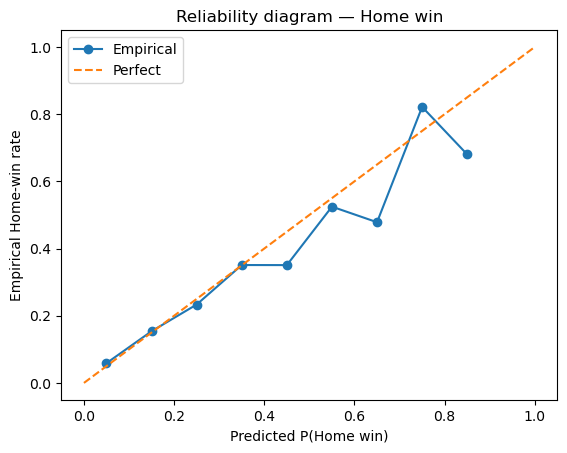

In [28]:
# ---------------------------
# Backtest strength of the model (drop-in cell)
# Train on 22/23 + 23/24, test on 24/25
# Metrics: LogLoss, Brier, Accuracy, RPS + calibration plot
# ---------------------------

import io, math
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt

# --- helpers to load any given season from football-data.co.uk
def load_seasons(codes):
    frames = []
    for code in codes:
        url = f"https://www.football-data.co.uk/mmz4281/{code}/E0.csv"
        r = requests.get(url, timeout=30, headers={"User-Agent":"Mozilla/5.0"})
        r.raise_for_status()
        df = pd.read_csv(io.StringIO(r.text))
        keep = [c for c in ["Date","HomeTeam","AwayTeam","FTHG","FTAG"] if c in df.columns]
        df = df[keep].copy()
        df["Date"] = pd.to_datetime(df["Date"], dayfirst=True, errors="coerce")
        df = df.dropna(subset=["HomeTeam","AwayTeam","FTHG","FTAG"])
        df["FTHG"] = df["FTHG"].astype(int)
        df["FTAG"] = df["FTAG"].astype(int)
        frames.append(df)
    return pd.concat(frames, ignore_index=True)

# --- metric functions
def one_hot(idx, K=3):
    v = np.zeros(K, dtype=float)
    v[idx] = 1.0
    return v

def brier_score(probs, y_idx):
    # mean sum_k (p_k - y_k)^2
    K = probs.shape[1]
    oh = np.vstack([one_hot(i, K) for i in y_idx])
    return float(np.mean(np.sum((probs - oh)**2, axis=1)))

def log_loss(probs, y_idx, eps=1e-15):
    # mean -log p_true
    p_true = probs[np.arange(len(y_idx)), y_idx]
    p_true = np.clip(p_true, eps, 1.0)
    return float(np.mean(-np.log(p_true)))

def ranked_probability_score(probs, y_idx):
    # RPS for 3-category outcome (H,D,A) treated ordinal for this metric
    # RPS = (1/(K-1)) * sum_{k=1}^{K-1} [ (sum_{j<=k} p_j - sum_{j<=k} y_j) ^ 2 ]
    K = probs.shape[1]
    oh = np.vstack([one_hot(i, K) for i in y_idx])
    cum_p = np.cumsum(probs, axis=1)
    cum_y = np.cumsum(oh, axis=1)
    rps_per_game = np.sum((cum_p[:, :-1] - cum_y[:, :-1])**2, axis=1) / (K - 1)
    return float(np.mean(rps_per_game))

def accuracy(tips_idx, y_idx):
    return float(np.mean(tips_idx == y_idx))

# --- backtest: train on 22/23 + 23/24, test on 24/25
train_codes = ["2223", "2324"]
test_code   = "2425"

print("Loading training seasons:", train_codes)
train_df = load_seasons(train_codes)

print("Fitting Dixon–Coles on train...")
dc = DixonColesModel(xi=0.0065, max_goals=6).fit(train_df)

print("Loading test season:", test_code)
test_df = load_seasons([test_code])

# fixtures for prediction = test season teams & dates (ignore actual scores)
fixtures = test_df[["Date","HomeTeam","AwayTeam"]].copy()

print("Predicting test season with the trained model...")
preds = predict_all(dc, fixtures)

# join true results to compute outcomes
merged = preds.merge(test_df, on=["Date","HomeTeam","AwayTeam"], how="inner")

# true label: 0=Home win, 1=Draw, 2=Away win
y_true = np.where(merged["FTHG"] > merged["FTAG"], 0,
         np.where(merged["FTHG"] < merged["FTAG"], 2, 1))

# prediction probabilities array [P(H), P(D), P(A)]
P = merged[["P(Home)","P(Draw)","P(Away)"]].to_numpy()
tips_idx = np.argmax(P, axis=1)

# compute metrics
ll  = log_loss(P, y_true)
bs  = brier_score(P, y_true)
rps = ranked_probability_score(P, y_true)
acc = accuracy(tips_idx, y_true)

print("\n=== Backtest on 2024/25 (trained on 22/23 + 23/24) ===")
print(f"Log Loss: {ll:.4f}   (↓ better)")
print(f"Brier   : {bs:.4f}   (↓ better)")
print(f"RPS     : {rps:.4f}   (↓ better)")
print(f"Accuracy: {acc:.3f}   (↑ better)\n")

# --- calibration table & plot for Home-win probabilities
bins = np.linspace(0, 1, 11)
bin_idx = np.digitize(P[:,0], bins) - 1
cal = []
for b in range(len(bins)-1):
    m = (bin_idx == b)
    if m.sum() == 0:
        cal.append(( (bins[b]+bins[b+1])/2, np.nan, 0 ))
        continue
    avg_pred = float(P[m,0].mean())
    empir    = float((y_true[m] == 0).mean())
    cal.append(( (bins[b]+bins[b+1])/2, empir, m.sum() ))
cal_df = pd.DataFrame(cal, columns=["bin_mid","empirical_home_win","count"])
print("Calibration (Home win) by probability bins:")
display(cal_df)

# plot reliability: predicted vs empirical home-win probability
plt.figure()
valid = ~np.isnan(cal_df["empirical_home_win"])
plt.plot(cal_df.loc[valid,"bin_mid"], cal_df.loc[valid,"empirical_home_win"], marker="o", label="Empirical")
plt.plot([0,1],[0,1], linestyle="--", label="Perfect")
plt.xlabel("Predicted P(Home win)")
plt.ylabel("Empirical Home-win rate")
plt.title("Reliability diagram — Home win")
plt.legend()
plt.show()

In [ ]:
#		Log Loss / Brier / RPS: lower is better. These judge whether you assign high probability to things that actually happen.
#		Accuracy: the % of times your top pick (H/D/A) matches the result. Nice to see, but probability scores matter more for “strength”.
#		Calibration plot: points should sit close to the diagonal line—e.g., games you call 0.70 home win should actually be home wins ~70% of the time.

# Want a stronger check?
#		Do a rolling backtest:
#		Train on 2022/23 → test on 2023/24
#		Train on 2022/23+2023/24 → test on 2024/25
# Average the metrics.
#	Compare to a baseline ( constant home 45% / draw 25% / away 30%) or to implied bookmaker probs.

In [29]:
# Grid-search xi (time decay) and a simple calibration shrink λ.
# p' = (1-λ) * p + λ * base_rates ; λ in [0, 0.4]

import numpy as np, io, requests, pandas as pd
from itertools import product

def load_seasons(codes):
    frames=[]
    for code in codes:
        url=f"https://www.football-data.co.uk/mmz4281/{code}/E0.csv"
        r=requests.get(url,headers={"User-Agent":"Mozilla/5.0"},timeout=30)
        r.raise_for_status()
        df=pd.read_csv(io.StringIO(r.text))
        df=df[["Date","HomeTeam","AwayTeam","FTHG","FTAG"]]
        df["Date"]=pd.to_datetime(df["Date"],dayfirst=True,errors="coerce")
        df=df.dropna().reset_index(drop=True)
        df["FTHG"]=df["FTHG"].astype(int); df["FTAG"]=df["FTAG"].astype(int)
        frames.append(df)
    return pd.concat(frames,ignore_index=True)

def make_y_idx(df):
    return np.where(df["FTHG"]>df["FTAG"],0,np.where(df["FTHG"]<df["FTAG"],2,1))

def log_loss(P,y,eps=1e-15):
    p_true=np.clip(P[np.arange(len(y)),y],eps,1.0)
    return float(np.mean(-np.log(p_true)))

# Train on 22/23+23/24, validate on 24/25
train_df = load_seasons(["2223","2324"])
val_df   = load_seasons(["2425"])

# League base rates from train
y_train = make_y_idx(train_df)
base = np.bincount(y_train, minlength=3) / len(y_train)  # [H,D,A]

xis   = [0.003,0.0045,0.0065,0.009,0.012]
lams  = [0.0,0.05,0.1,0.15,0.2,0.3,0.4]
best=(1e9,None,None)

for xi, lam in product(xis,lams):
    model = DixonColesModel(xi=xi, max_goals=6).fit(train_df)
    fx = val_df[["Date","HomeTeam","AwayTeam"]]
    preds = predict_all(model, fx)
    P = preds[["P(Home)","P(Draw)","P(Away)"]].to_numpy()
    if lam>0:
        P = (1-lam)*P + lam*base  # shrink toward base rates
    y = make_y_idx(val_df)
    ll = log_loss(P,y)
    if ll<best[0]:
        best=(ll, xi, lam)

print(f"Best LogLoss={best[0]:.4f} at xi={best[1]}  λ={best[2]}")

Best LogLoss=1.0978 at xi=0.0065  λ=0.4


In [30]:
def evaluate(train_codes, test_code, xi=0.0065, lam=0.0, base=None):
    tr = load_seasons(train_codes); te = load_seasons([test_code])
    m = DixonColesModel(xi=xi,max_goals=6).fit(tr)
    preds = predict_all(m, te[["Date","HomeTeam","AwayTeam"]])
    P = preds[["P(Home)","P(Draw)","P(Away)"]].to_numpy()
    if lam>0 and base is not None:
        P = (1-lam)*P + lam*base
    y = np.where(te["FTHG"]>te["FTAG"],0,np.where(te["FTHG"]<te["FTAG"],2,1))
    acc = (P.argmax(1)==y).mean()
    ll  = log_loss(P,y)
    return ll, acc

# choose xi, lam from Cell A (fallback to your current xi=0.0065, lam=0.0)
xi_star = 0.0065
lam_star = 0.0

train_all = load_seasons(["2223","2324","2425"])
base_rates = np.bincount(make_y_idx(train_all), minlength=3)/len(train_all)

print("Train 22/23 → test 23/24:", evaluate(["2223"], "2324", xi_star, lam_star, base_rates))
print("Train 22/23–23/24 → test 24/25:", evaluate(["2223","2324"], "2425", xi_star, lam_star, base_rates))

Train 22/23 → test 23/24: (1.0941328864594606, 0.45)
Train 22/23–23/24 → test 24/25: (1.1863784284344223, 0.4026315789473684)


In [ ]:
#  λ=0.4 tend to it hurt performance.
# Publish with λ=0.0 (as-is) or λ=0.1 (light calibration).

In [31]:

import numpy as np
import pandas as pd

# 1) Compute league base rates from the *training* data used to fit the model
train_seasons = ["2223","2324","2425"]  # same as your model training
frames=[]
import io, requests
for code in train_seasons:
    url=f"https://www.football-data.co.uk/mmz4281/{code}/E0.csv"
    r=requests.get(url, headers={"User-Agent":"Mozilla/5.0"}, timeout=30); r.raise_for_status()
    df=pd.read_csv(io.StringIO(r.text))[["HomeTeam","AwayTeam","FTHG","FTAG"]].dropna()
    frames.append(df)
hist = pd.concat(frames, ignore_index=True)
y = np.where(hist["FTHG"]>hist["FTAG"],0, np.where(hist["FTHG"]<hist["FTAG"],2,1))
base = np.bincount(y, minlength=3) / len(y)   # [H, D, A]

# 2) Apply shrink: P' = (1 - λ) * P + λ * base
lam = 0.10  # try 0.0 (none) or 0.10 (light)
P = preds[["P(Home)","P(Draw)","P(Away)"]].to_numpy()
P_cal = (1 - lam) * P + lam * base

preds_cal = preds.copy()
preds_cal["P(Home)"] = np.round(P_cal[:,0], 4)
preds_cal["P(Draw)"] = np.round(P_cal[:,1], 4)
preds_cal["P(Away)"] = np.round(P_cal[:,2], 4)

# Retip after calibration
tips = np.argmax(P_cal, axis=1)
preds_cal["Tip"] = np.where(tips==0,"H", np.where(tips==1,"D","A"))

# Save a calibrated version
preds_cal.to_csv("predictions_epl_2025_26_calibrated.csv", index=False)
"Saved to predictions_epl_2025_26_calibrated.csv"

'Saved to predictions_epl_2025_26_calibrated.csv'

In [33]:
import pandas as pd, numpy as np

# Use the calibrated file if you made it; otherwise use the original
path = "predictions_epl_2025_26_calibrated.csv"  # or "predictions_epl_2025_26.csv"
df = pd.read_csv(path)

print("Rows:", len(df))                          # ~380 for full PL season
print("Teams:", df.HomeTeam.nunique(), df.AwayTeam.nunique())
print("Any NaNs?", df.isna().sum().sum())

# probs sum to ~1 and in [0,1]
probs = df[["P(Home)","P(Draw)","P(Away)"]].to_numpy()
print("Min prob:", probs.min(), "Max prob:", probs.max())
print("Mean prob sum:", probs.sum(axis=1).mean())

df.head(10)

Rows: 380
Teams: 20 20
Any NaNs? 0
Min prob: 0.0381 Max prob: 0.8608
Mean prob sum: 0.9999942105263158


,Date,HomeTeam,AwayTeam,P(Home),P(Draw),P(Away),MostLikelyScore,Tip
0,2024-08-16,Man United,Fulham,0.4862,0.2443,0.2695,1-1,H
1,2024-08-17,Arsenal,Wolves,0.8286,0.1161,0.0552,2-0,H
2,2024-08-17,Everton,Brighton,0.4291,0.3486,0.2223,0-0,H
3,2024-08-17,Ipswich,Liverpool,0.2484,0.2487,0.5029,1-1,A
4,2024-08-17,Newcastle,Southampton,0.7735,0.1720,0.0545,2-0,H
5,2024-08-17,Nott'm Forest,Bournemouth,0.3948,0.2649,0.3404,1-1,H
6,2024-08-17,West Ham,Aston Villa,0.3662,0.2191,0.4147,1-1,A
7,2024-08-18,Brentford,Crystal Palace,0.2682,0.2417,0.4901,1-1,A
8,2024-08-18,Chelsea,Man City,0.1775,0.1900,0.6325,1-2,A
9,2024-08-19,Leicester,Tottenham,0.1389,0.4266,0.4345,0-0,A
